In [54]:
import matplotlib.pyplot as plt
import datetime

def get_pwr_elapsed_times(lines):
    y = []
    timestamps = []
    for i, line in enumerate(lines):
        if i == 0 or line.startswith('#') or line.startswith('COMPLETED'):
            continue
        vals = line.strip().split(',')
        timestamp_str = vals[0]
        y_val = float(vals[1])
        timestamp = datetime.datetime.strptime(timestamp_str, '%Y/%m/%d %H:%M:%S.%f')
        timestamps.append(timestamp)
        y.append(y_val)
    
    start_time = timestamps[0]
    elapsed_times = [(t - start_time).total_seconds()*1000 for t in timestamps]
    return y, elapsed_times

def pad(y, target_len):
    return y + (target_len-len(y))*[None]
    

# Split the lines into timestamp, x, and y values
def gen_plot(lines1, lines2):
    y1, elapsed_times1 = get_pwr_elapsed_times(lines1)
    y2, elapsed_times2 = get_pwr_elapsed_times(lines2)
    
    # Create a plot
#     fig, axs = plt.subplots(nrows=2, ncols=1)
#     axs[0].plot(elapsed_times1, y1)
#     axs[1].plot(elapsed_times2, y2)
#     axs[0].set_xlim(min(elapsed_times1), max(elapsed_times1))
#     axs[1].set_xlim(min(elapsed_times2), max(elapsed_times2))
#     x_ticks1 = range(int(min(elapsed_times1)), int(max(elapsed_times1))+1, 2500)
#     x_ticks2 = range(int(min(elapsed_times2)), int(max(elapsed_times2))+1, 2500)
#     axs[0].set_xticks(x_ticks1)
#     axs[1].set_xticks(x_ticks2)
#     plt.xlabel('Time (ms)')
#     plt.ylabel('Power Consumption (W)')
#     plt.title('Power Consumption Over Time')
    
    fig = plt.figure(figsize=(17, 6))
    # pad y1 with None values
    y1 = pad(y1, len(y2))
    x_ticks = range(int(min(elapsed_times2)), int(max(elapsed_times2))+1, 5000)
    plt.xticks(x_ticks)
    plt.plot(elapsed_times2, y1, label='1024x1024')
    plt.plot(elapsed_times2, y2, label='2048x2048')
    plt.xlabel('Time (ms)')
    plt.ylabel('Power Consumption (W)')
    plt.title('Power Consumption Over Time')
    plt.legend()
    plt.show()

# Open the text file and read in the data
with open('../data/gpu_pwr_naive_0_50_10_32.txt', 'r') as f:
    lines1 = f.readlines()
    
with open('../data/gpu_pwr_naive_0_50_11_32.txt', 'r') as f:
    lines2 = f.readlines()

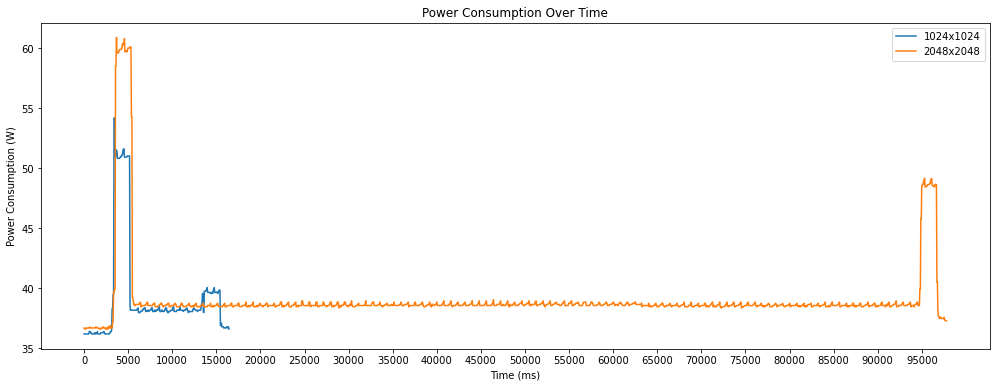

In [55]:
gen_plot(lines1, lines2)

In [71]:
import numpy as np
import scipy
from scipy.integrate import simps

In [65]:
y2, elapsed_times2 = get_pwr_elapsed_times(lines2)
area2 = simps(y2, elapsed_times2)/1000
time2 = max(elapsed_times2)/1000

In [66]:
y1, elapsed_times1 = get_pwr_elapsed_times(lines1)
area1 = simps(y1, elapsed_times1)/1000
time1 = max(elapsed_times1)/1000

In [92]:
def get_power_baseline(y1, y2):
    sample = int(3000/50)
    baseline = sum(y1[0:sample]+y2[0:sample])/(sample*2)
    return baseline

In [93]:
def normalize_power(baseline, y1, y2):
    return [y-baseline for y in y1], [y-baseline for y in y2]

In [99]:
baseline = get_power_baseline(y1, y2)
print(baseline)
y1_n, y2_n = normalize_power(baseline, y1, y2)
area1_n = simps(y1_n, elapsed_times1)/1000
area2_n = simps(y2_n, elapsed_times2)/1000
print(area1_n, area2_n)

36.48374999999999
47.33791110599452 258.22897595674755


[16.453 97.786] [ 47.33791111 258.22897596] 2.5929335552697306 4.676375321141497


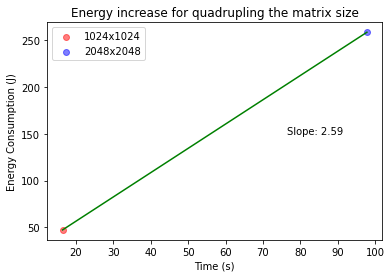

In [98]:
x = np.array([time1, time2])
y = np.array([area1_n, area2_n])
m, b = np.polyfit(x, y, 1)
print(x, y, m, b)
plt.scatter(time1, area1_n, c='r',  alpha=0.5, label='1024x1024')
plt.scatter(time2, area2_n, c='b',  alpha=0.5, label='2048x2048')
plt.plot(x, m*x + b, color='green')
plt.text(0.8, 0.5, f'Slope: {m:.2f}', transform=plt.gca().transAxes, ha='center', va='center')
plt.xlabel('Time (s)')
plt.ylabel('Energy Consumption (J)')
plt.title('Energy increase for quadrupling the matrix size')
plt.legend()
plt.show()